# 目录
1. 稳定性检测
2. 平稳性处理  
    2.1 对数变化  
    2.2 平滑  
    2.3 差分  
    2.4 分解  
3. 时间序列建模

In [1]:
import datetime
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']     #用来正常显示中文
plt.rcParams['axes.unicode_minus']=False      # 用来正常显示负号
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.seasonal import seasonal_decompose

-----原始数据-----
   Passengers
0         112
1         118
2         132
3         129
4         121
-----修改后数据-----
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Freq: M, Name: Passengers, dtype: int64


/home/jacky/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ts_plot of passenger')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


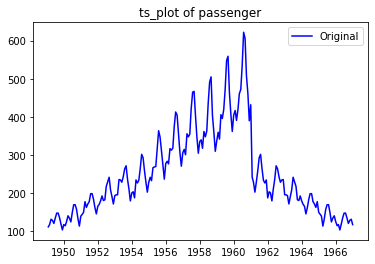

In [2]:
# 数据变化
data = pd.read_csv('passenger.csv',sep = '\t')
print("-----原始数据-----")
print(data.head())
df1 = data.copy()
for i in range(len(data['Passengers'])//2):
    tmp = data['Passengers'][(int(144/2) - i)]
    df2 = pd.DataFrame([[tmp]],columns=['Passengers'])
    df1 = pd.concat([df1,df2],ignore_index=True)
data = df1    
data.index = pd.date_range(start = '19490101',periods = 216,freq = 'M')
data = data['Passengers']
print("-----修改后数据-----")
print(data.head())
plt.plot(data, color = 'blue',label = 'Original')
plt.legend(loc = 'best')
plt.title('ts_plot of passenger')

# 读取数据

-----原始数据-----
   Passengers
0         112
1         118
2         132
3         129
4         121
-----修改后数据-----
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Freq: M, Name: Passengers, dtype: int64


Text(0.5, 1.0, 'ts_plot of passenger')

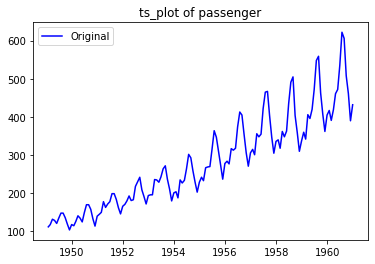

In [3]:
data = pd.read_csv('passenger.csv',sep = '\t')
print("-----原始数据-----")
print(data.head())
data.index = pd.date_range(start = '19490101',periods = 144,freq = 'M')
data = data['Passengers']
print("-----修改后数据-----")
print(data.head())
plt.plot(data, color = 'blue',label = 'Original')
plt.legend(loc = 'best')
plt.title('ts_plot of passenger')

# 1. 稳定性检测 
* **绘制滚动统计**：我们可以绘制移动平均数和移动方差，观察它是否随着时间变化。
* **ADF检验**：这是一种检查数据稳定性的统计测试。无效假设：时间序列是不稳定的。测试结果由测试统计量和一些置信区间的临界值组成。如果“测试统计量”少于“临界值”，我们可以拒绝无效假设，并认为序列是稳定的。或者根据前面提高的p值检验，如果p值小于显著性水平，我们可以拒绝无效假设，认为序列稳定。

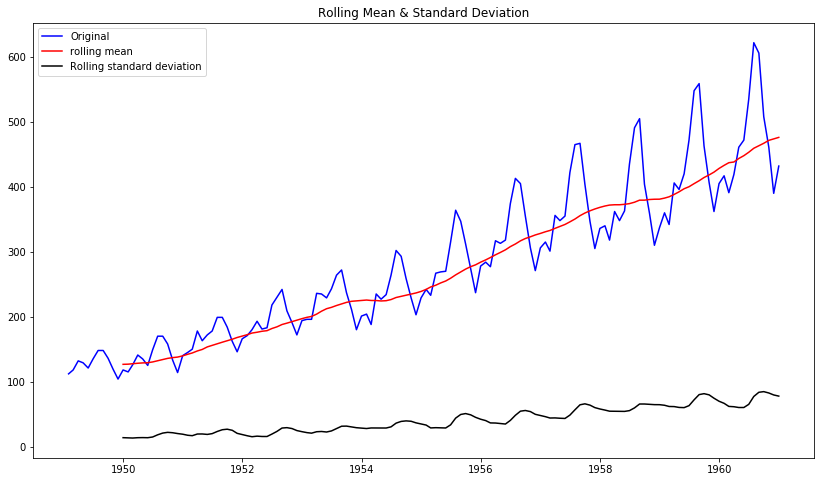

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [4]:
def test_stationarity(timeseries):
    
    #这里以一年为一个窗口，每一个时间t的值由它前面12个月（包括自己）的均值代替，标准差同理。
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plot rolling statistics:
    fig = plt.figure(figsize = (14,8))
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling standard deviation')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    
    #Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' % key] = value
    
    print(dfoutput)
test_stationarity(data)

* Test statistic：代表检验统计量
* p-value：代表p值检验的概率
* Lags used：使用的滞后k，autolag=AIC时会自动选择滞后
* Number of Observations Used：样本数量
* Critical Value(5%) : 显著性水平为5%的临界值。
# ADF检验
* 假设是存在单位根，即不平稳；
* 显著性水平，1%：严格拒绝原假设；5%：拒绝原假设，10%类推。
* 看P值和显著性水平a的大小，p值越小，小于显著性水平的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的
* 看检验统计量和临界值，检验统计量小于临界值的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的

根据上文提到的p值检验以及上面的结果，我们可以发现p=0.99>10%>5%>1%, 并且检验统计量0.815>>-2.58>-2.88>-3.48，因此可以认定原序列不平稳。

先让我们弄明白是什么导致时间序列不稳定。两个主要原因。

* **趋势-随着时间产生不同的平均值。** 举例：在飞机乘客这个案例中，我们看到总体上，飞机乘客的数量是在不断增长的。
* **季节性-特定时间框架内的变化。** 举例：在特定的月份购买汽车的人数会有增加的趋势，因为车价上涨或者节假日到来。

我们的基本原理是，通过建模并估计趋势和季节性这些因素，并从时间序列中移除，来获得一个稳定的时间序列，然后再使用统计预测技术来处理时间序列，最后将预测得到的数据，通过加入趋势和季节性等约束，来回退到原始时间序列数据。

# 2. 平稳性处理
## 2.1 对数变换
对数变换主要是为了减小数据的波动幅度，剔除序列可能存在的异方差，**相当于增加了一个惩罚机制，数据越大其惩罚越大，数据越小惩罚越小。**  
例如：np.log(10000)=9.2 ,np.log(1000)=7.0 ,np.log(100)=4.6  
注意：变换的序列需要满足大于0，小于0的数据不存在对数变换。  
**这可以采用对数, 平方根,立方跟等等。**


### 结论：虽然数据依然未通过平稳性检验，序列的趋势性依然存在，但序列明显比对数变换前更加平稳，因此，经常可以吧对数变换作为平稳化处理的第一步。


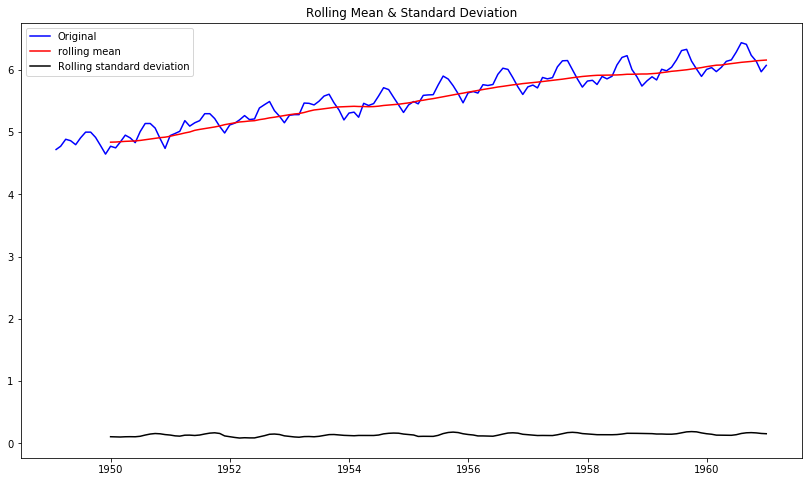

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [5]:
ts_log = np.log(data)
test_stationarity(ts_log)

## 序列剔除周期性
## 2.2 平滑
### 2.2.1取滚动平均数
思路：平滑法具体分为移动平均法和指数平均法；移动平均即利用一定时间间隔内的平均值作为某一期的估计值，而指数平均则是用变权的方法来计算均值

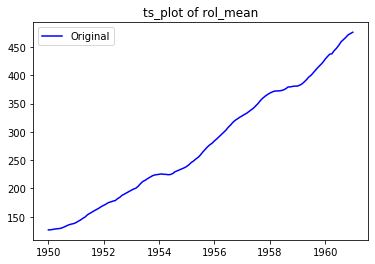

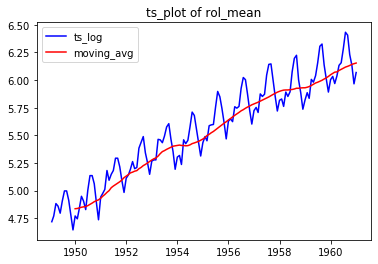

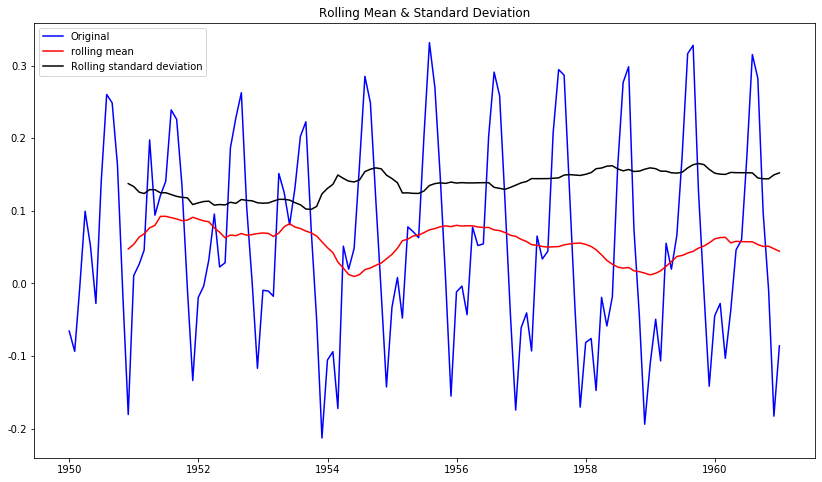

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64
可以发现通过了5%和10%的显著性检验，即在该水平下，拒绝原假设，认为序列是平稳的，但是没有通过1%的检验。


In [6]:
#使用窗口为12的移动平均进行处理，去除序列周期性
rol_mean = data.rolling(window = 12).mean()
rol_mean.dropna(inplace = True)
moving_avg = ts_log.rolling(window = 12).mean()
moving_avg.dropna(inplace = True)
#去除周期性后的时序图，只具有趋势性
plt.plot(rol_mean, color = 'blue',label = 'Original')
plt.legend(loc = 'best')
plt.title('ts_plot of rol_mean')
plt.show()
plt.plot(ts_log, color = 'blue',label = 'ts_log')
plt.plot(moving_avg, color = 'red',label = 'moving_avg')
plt.legend(loc = 'best')
plt.title('ts_plot of rol_mean')

# 对数变换 + 平滑 +　差分
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)
print("可以发现通过了5%和10%的显著性检验，即在该水平下，拒绝原假设，认为序列是平稳的，但是没有通过1%的检验。")

### 2.2.2 指数加权移动平均

前面移动平均数需要指定window,并且对所有的数一视同仁；这里采用指数加权移动平均方法，会对当前的数据加大权重，对过去的数据减小权重。halflife半衰期，用来定义衰减量。其他参数,如跨度span和质心com也可以用来定义衰减。

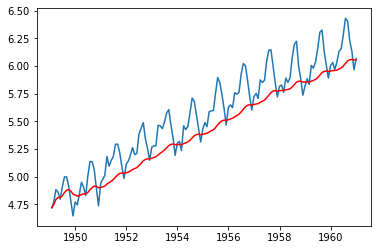

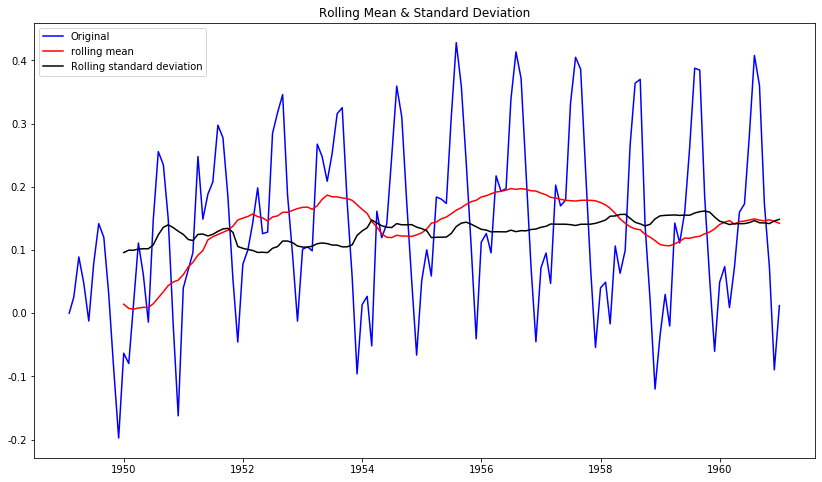

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64
可以发现，经过指数移动平均后，再做差的结果，已经能够通过1%显著性水平检验了。


In [7]:
# expwighted_avg = ts_log.ewm(span = 12).mean()
expwighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color = 'red')

# 做差
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)
print("可以发现，经过指数移动平均后，再做差的结果，已经能够通过1%显著性水平检验了。")

## 2.3 差分
思路：蕴含着固定周期的序列进行步长为周期长度的差分运算，就可以剔除周期性，甚至可以剔除趋势性是序列平稳。  
注意：步差分 和 阶差分不同。  
步差分就是相隔某一时段的数值相减，得到新的序列。阶差分类似于求导数，后一阶都在前一阶的基础上再次执行一阶差分。   
**（1）序列蕴含显著的线性趋势，1阶差分就可以剔除趋势性，实现平稳**  
**（2）序列蕴含曲线趋势，通常低阶差分(2阶或3阶)就可以剔除趋势性，实现平稳**

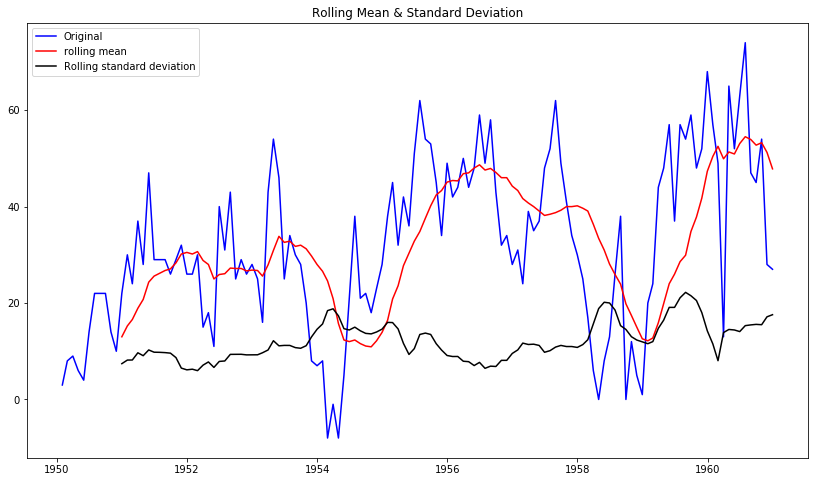

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


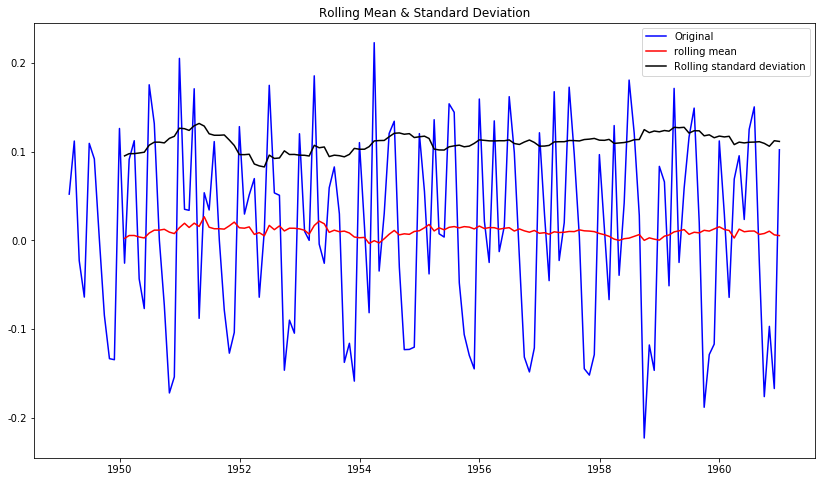

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64
可以发现只通过了10%的显著性水平检验。


In [8]:
#12步差分
diff_12 = data.diff(12)
diff_12.dropna(inplace = True)
#去除周期性后的时序图，只具有趋势性
test_stationarity(diff_12)

#步长为1的一阶差分
ts_log_diff = ts_log - ts_log.shift(periods = 1)
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)
print("可以发现只通过了10%的显著性水平检验。")

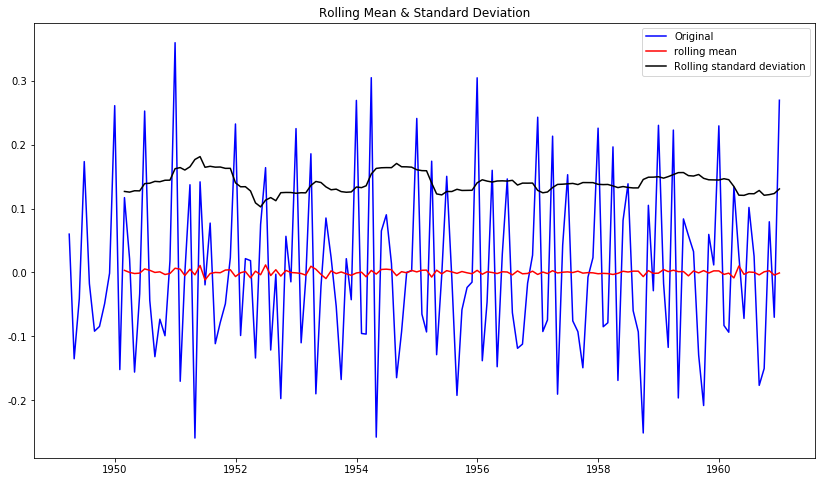

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical value (1%)           -3.482501e+00
Critical value (5%)           -2.884398e+00
Critical value (10%)          -2.578960e+00
dtype: float64
对二阶差分进行adf检验,可以看到，二阶差分，p值非常小，小于1%，检验统计量也明显小于%1的临界值。因此认定为很平稳.


In [9]:
#一阶差分：Y(k)=X(k+1)-X(k)
#二阶差分：Y(k)的一阶差分Z(k)=Y(k+1)-Y(k)=X(k+2)-2*X(k+1)+X(k)为此函数的二阶差分
ts_log_diff = ts_log - ts_log.shift(periods = 1)
ts_log_diff2 = ts_log_diff - ts_log_diff.shift(periods = 1)
ts_log_diff2.dropna(inplace = True)
test_stationarity(ts_log_diff2)
print("对二阶差分进行adf检验,可以看到，二阶差分，p值非常小，小于1%，检验统计量也明显小于%1的临界值。因此认定为很平稳.")

### 2.4 分解
趋势分解法  
分解(decomposing) 可以用来把时序数据中的趋势和季节性数据都分离出来:   
返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)


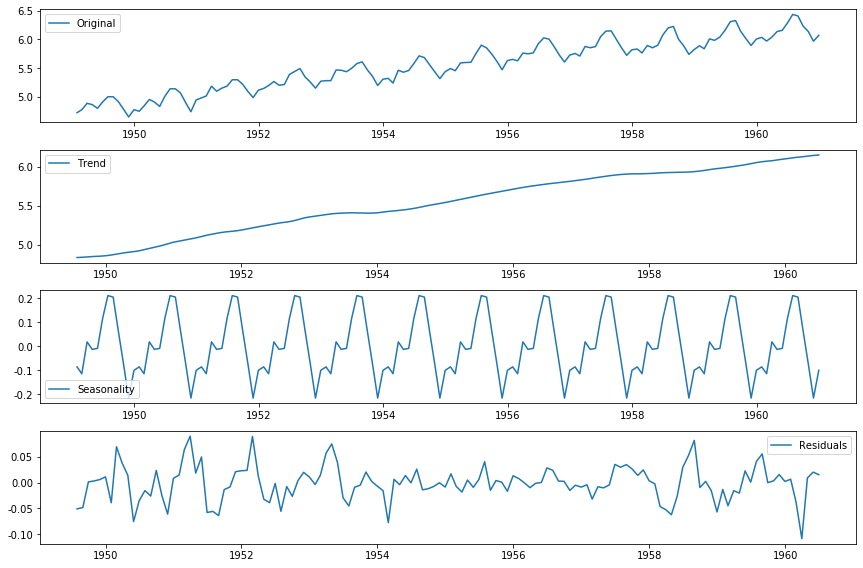

In [10]:
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(ts_log,label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413);
plt.plot(seasonal,label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

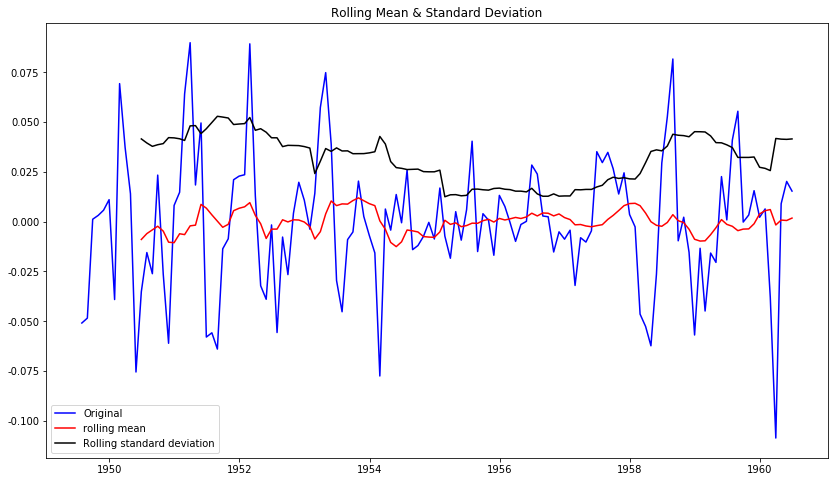

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical value (1%)           -3.485122e+00
Critical value (5%)           -2.885538e+00
Critical value (10%)          -2.579569e+00
dtype: float64
对残差进行ADF检验，可以发现序列非常平稳。


In [11]:
#对残差进行ADF检验
#可以发现序列非常平稳
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)
print("对残差进行ADF检验，可以发现序列非常平稳。")

# 小结
### 剔除周期性：平滑法，步差分（季节差分）
### 剔除趋势性： 对数变换，阶差分 （趋势差分）

In [13]:
# #对序列的移动平均值rol_mean执行差分平稳化，由于具有明显的线性趋势，故做一阶差分就可得到平稳序列
# ts_diff_1 = rol_mean.diff(1)
# ts_diff_1.dropna(inplace=True)
# test_stationarity(ts_diff_1)
# #结论：1阶差分后p-value<0.05,序列平稳

# #白噪声检验
# ts_diff_1 = rol_mean.diff(1)
# ts_diff_1.dropna(inplace=True)
# acorr_ljungbox(ts_diff_1,lags=60)[1] 


# #diff_12的白噪声检验，H0:序列是白噪声序列，p<0.05拒绝原假设，认为diff_12是非白噪声序列
# #结论：移动平均值rol_mean的1阶差分序列可以用于建立ARMA模型

# 3. 时间序列建模
**平稳性检验**  
平稳性检验的目的是为了判断序列是否平稳，如果不平稳，需要采取一定的措施进行平稳性处理，常见的方法是差分，我们需要选择合适的差分阶数。只要能够通过1%显著性检测，差分阶数就是合理的，我们希望阶数越小越好。  
**ADF检验**  
ADF检验前文已经说过，用于判断序列是否平稳。  
**自相关图和偏自相关图**  
前面我们对数据进行ADF检验，判断序列是否平稳，这里我们使用自相关图和偏自相关图对数据平稳性再次进行验证，一阶差分如下图：

### 选用非周期性数据建模，平稳序列建立ARMA模型，非平稳序列建立ARIMA模型；
### 2.2中已经确定移动平均序列是平稳非白噪声序列，本例选用移动平均序列rol_mean建立ARIMA模型
### 建模步骤：
### （1）模型定阶：相关图 + 自动调参
###    自相关图偏主观，自动调参偏客观，二者应结合起来，多次尝试并比较，最终找到最优参数，类似机器学习的寻找最有参数，得到局部最优解，未必是全局最优。
### （2）模型检验：参数检验 + 残差检验
### （3）预测结果：差分还原

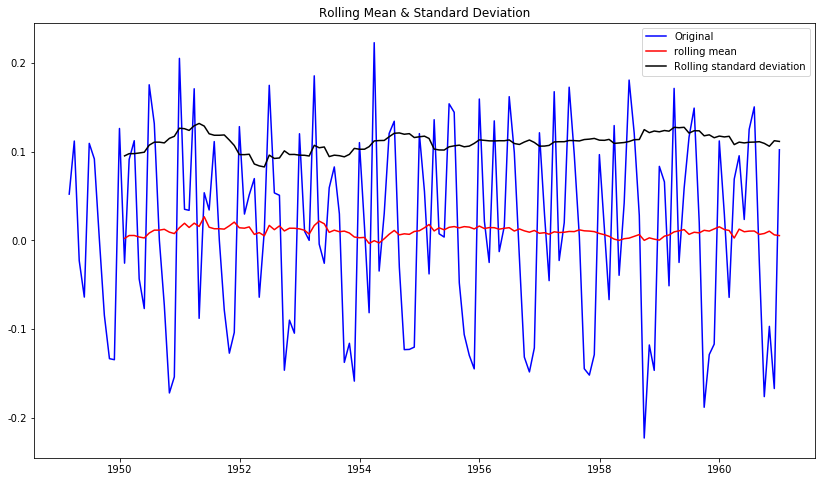

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64
可以看出，一阶差分自相关和偏相系数拖尾特点明显。p=1,q=1,拖尾是指序列以指数率单调递减或震荡衰减，而截尾指序列从某个时点变得非常小


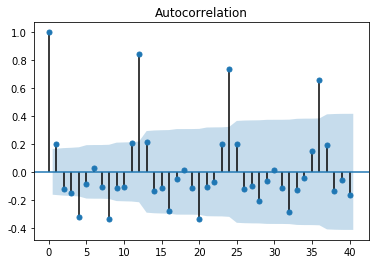

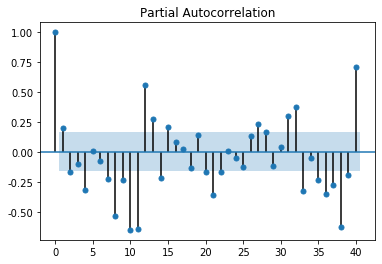

In [14]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

#模型定阶
plot_acf(ts_log_diff, lags = 40)
plot_pacf(ts_log_diff, lags = 40)
print("可以看出，一阶差分自相关和偏相系数拖尾特点明显。p=1,q=1,拖尾是指序列以指数率单调递减或震荡衰减，而截尾指序列从某个时点变得非常小")


In [15]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print(last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace = True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果

In [ ]:
#注意这里面使用的ts_log_diff是经过合适阶数的差分之后的数据，上文中提到ARIMA该开源库，不支持3阶以上的#差分。所以我们需要提前将数据差分好再传入
def _proper_model(ts_log_diff, maxLag):
    best_p = 0 
    best_q = 0
    best_bic = sys.maxsize
    best_model = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order = (p, q))
            try:
                results_ARMA = model.fit(disp = -1)
            except:
                continue
            bic = results_ARMA.bic
            print(bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    return best_p,best_q,best_model
# _proper_model(ts_log_diff, 10) #对一阶差分求最优p和q

Text(0.5, 1.0, 'RSS:1.5476')

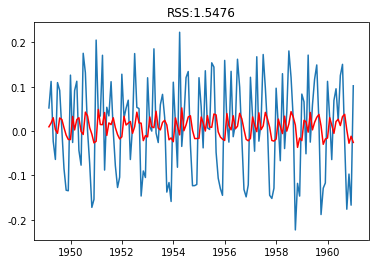

In [16]:
# AR模型，q=0
#RSS是残差平方和
# disp为-1代表不输出收敛过程的信息，True代表输出
model = ARIMA(ts_log,order = (1,1,0)) #第二个参数代表使用了一阶差分
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red') #红色线代表预测值
plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-ts_log_diff)**2))#残差平方和


Text(0.5, 1.0, 'RSS: 1.5245')

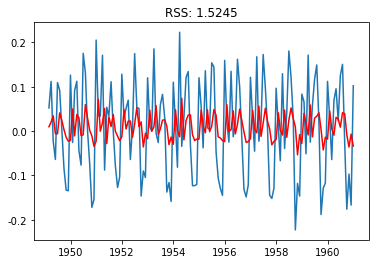

In [17]:
#MA模型 p=0
model = ARIMA(ts_log,order = (0,1,1))
results_MA = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))


可以发现，ARIMA在AR和MA基础上，RSS有所减少，故模型有所提高。我们使用上文中提高的p和q选择方法，对一阶差分结果进行p和q选择。


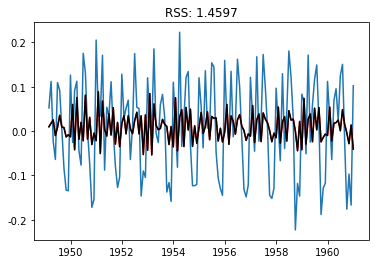

In [19]:
#ARIMA
model = ARIMA(ts_log, order = (1, 1, 1))  
results_ARIMA = model.fit(disp = -1)  #不展示信息
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')#和下面这句结果一样
plt.plot(results_ARIMA.predict(), color = 'black')#predict得到的就是fittedvalues，只是差分的结果而已。还需要继续回退
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
print("可以发现，ARIMA在AR和MA基础上，RSS有所减少，故模型有所提高。")

我们使用上文中提高的p和q选择方法，对一阶差分结果进行p和q选择。,故可以使用p=8,q=7再次进行测试。得到如下结果


/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RSS: 0.3939')

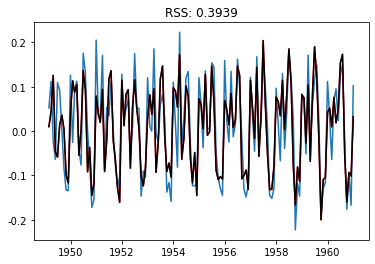

In [21]:
print("我们使用上文中提高的p和q选择方法，对一阶差分结果进行p和q选择。,故可以使用p=8,q=7再次进行测试。得到如下结果")
# best_p,best_q,best_model= _proper_model(ts_log_diff, 10) #对一阶差分求最优p和q
best_p = 8
best_q = 7
model = ARIMA(ts_log, order = (best_p, 1, best_q))  
results_ARIMA = model.fit(disp = -1)  #不展示信息
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')#和下面这句结果一样
plt.plot(results_ARIMA.predict(), color = 'black')#predict得到的就是fittedvalues，只是差分的结果而已。还需要继续回退
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [48]:
# d = [1, 1] # 定义差分序列
# ts_log = np.log(data)
# diffed_ts = diff_ts(ts_log, d) 
# model = ARIMA(ts_log, order = (8, 1, 7)) #构建模型
# model = model.fit(disp = -1)
# predict_ts = model.predict() #预测，这是对训练数据的预测
# diff_recover_ts = predict_diff_recover(predict_ts, d)
# log_recover = np.exp(diff_recover_ts) #恢复对数前数据，该数据可以和原始数据ts进行作图对比

[6.068425588244111]
[6.068425588244111, 0.10227884912041851]


/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[6.068425588244111]


/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 14.0250')

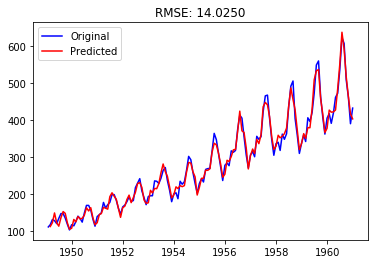

In [97]:
# 数据还原
ts_log_diff = diff_ts(ts_log, d = [1])#调用差分方法，方便后续还原
model = ARIMA(ts_log, order = (8, 1, 7))  #建模
results_ARIMA = model.fit(disp = -1)  #fit
predict_ts = results_ARIMA.predict() #对训练数据进行预测

#还原
diff_recover_ts = predict_diff_recover(predict_ts, d = [1])#恢复数据
log_recover = np.exp(diff_recover_ts)#还原对数前数据

#绘图
#ts = ts[log_recover.index]#排除空的数据
plt.plot(data,color = "blue",label = 'Original')
plt.plot(log_recover,color = 'red',label = 'Predicted')
plt.legend(loc = 'best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-data[1:])**2)/len(data[1:])))#RMSE,残差平方和开根号，即标准差


In [98]:
## 建模方法二

In [100]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
model = ARMA(ts_diff_2, order=(1, 1)) 
result_arma = model.fit(disp=-1, method='css')

/usr/local/python3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


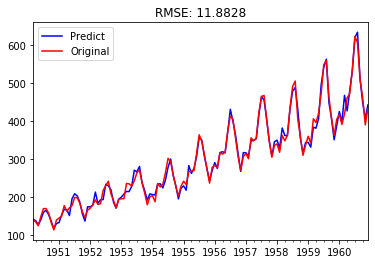

In [102]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

data = data[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
data.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-data)**2)/data.size))
plt.show()

In [105]:
result_arma.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 -1077.3559
Dependent Variable: Passengers       Log-Likelihood:      548.41    
Date:               2019-12-29 02:27 Scale:               1.0000    
No. Observations:   131              Method:              css       
Df Model:           3                Sample:              03-31-1950
Df Residuals:       127                                   12-31-1960
Converged:          0.0000           S.D. of innovations: 0.004     
No. Iterations:     30.0000          HQIC:                -1084.165 
AIC:                -1088.8261                                      
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                 0.0000   0.0002  0.0283 0.9774 -0.0003  0.0003
ar.L1.Passengers      0.1630   0.2590  0.6296 0.5301 -0.3445  0.6706
ma.L1.Passengers     -0.5404   0.2295 -2.3547 0.0201 -0.9902 -0.0906
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            6.1336             0.0000           6.1336             0.0000
MA.1            1.8504             0.0000           1.8504             0.0000
====================================================================

"""

In [104]:
# https://www.cnblogs.com/foley/p/5582358.html
# diffed_ts = diff_ts(ts_log, d=[12, 1])
# model = arima_model(diffed_ts)
# model.certain_model(1, 1)
# predict_ts = model.properModel.predict()
# diff_recover_ts = predict_diff_recover(predict_ts, d=[12, 1])
# log_recover = np.exp(diff_recover_ts)

# 预测未来走势
使用forecast进行预测，参数为预测值个数。这个得到的就是进行自动差分还原后的数据，因为我们建立模型的时候ARIMA(p,1,q), 第二个参数就是差分阶数，forecast会将结果恢复回差分前的数据，因此我们直接将结果通过np.exp来恢复到最原始数据即可。但是ARIMA只支持最多2阶差分，因此我们可以使用ARMA模型，将我们手动差分完的数据传入。最后预测的时候，使用我们自定义的差分还原方法，对预测得到的值进行差分还原。

1961-01-01    6.153369
1961-02-01    6.120038
1961-03-01    6.136623
1961-04-01    6.191004
1961-05-01    6.271204
dtype: float64
1961-01-01    470.299358
1961-02-01    454.882128
1961-03-01    462.489038
1961-04-01    488.335972
1961-05-01    529.113807
1961-06-01    603.450716
1961-07-01    718.210682
1961-08-01    660.642195
1961-09-01    576.531713
1961-10-01    527.328241
1961-11-01    462.210343
1961-12-01    486.062586
dtype: float64


Text(0.5, 1.0, 'forecast')

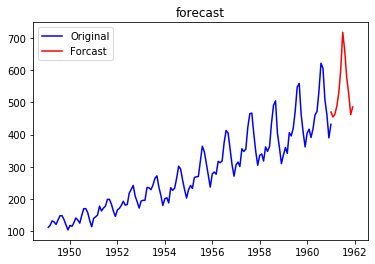

In [95]:
# forecast方法会自动进行差分还原，当然仅限于支持的1阶和2阶差分
forecast_n = 12 #预测未来12个月走势
forecast_ARIMA_log = results_ARIMA.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]

#定义获取连续时间，start是起始时间，limit是连续的天数,level可以是day,month,year
import arrow
def get_date_range(start, limit, level = 'month',format = 'YYYY-MM-DD'):
    start = arrow.get(start, format)  
    result = (list(map(lambda dt: dt.format(format) , arrow.Arrow.range(level, start, limit = limit))))
    dateparse2 = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
    return map(dateparse2, result)

# 预测从1961-01-01开始，也就是我们训练数据最后一个数据的后一个日期
new_index = get_date_range('1961-01-01', forecast_n)
forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy = True, index = new_index)
print(forecast_ARIMA_log.head())

# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print(forecast_ARIMA)
plt.plot(data,label = 'Original',color = 'blue')
plt.plot(forecast_ARIMA, label = 'Forcast',color = 'red')
plt.legend(loc = 'best')
plt.title('forecast')

-----原始数据-----
   Passengers
0         112
1         118
2         132
3         129
4         121
-----修改后数据-----
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Freq: M, Name: Passengers, dtype: int64
残差白噪声检验:
[0.74085509 0.5005495  0.61050657 0.64158811 0.73158339 0.83398163
 0.87561572 0.92090962 0.65065742 0.6297324  0.71380773 0.59275657
 0.62100527 0.69545702 0.74216618 0.61451558 0.67966416 0.74058493]


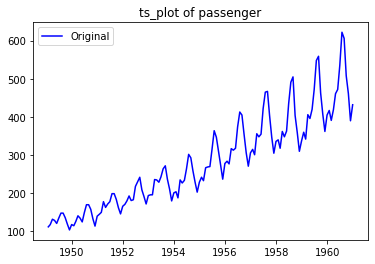

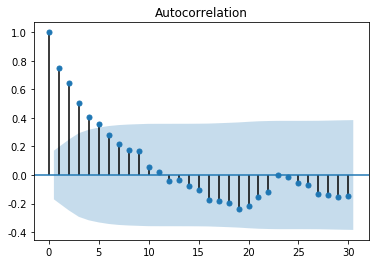

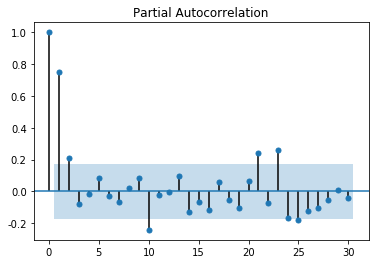

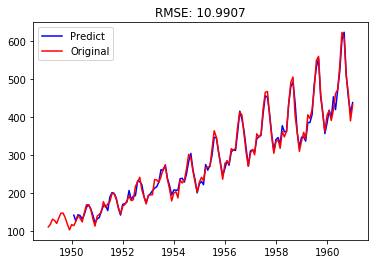

1949-01-31         NaN
1949-02-28         NaN
1949-03-31         NaN
1949-04-30         NaN
1949-05-31         NaN
1949-06-30         NaN
1949-07-31         NaN
1949-08-31         NaN
1949-09-30         NaN
1949-10-31         NaN
1949-11-30         NaN
1949-12-31         NaN
1950-01-31    0.239873
1950-02-28    0.012805
1950-03-31    0.019048
1950-04-30    0.050288
1950-05-31    0.057242
1950-06-30   -0.029981
1950-07-31   -0.038569
1950-08-31   -0.001220
1950-09-30    0.007725
1950-10-31    0.071741
1950-11-30    0.075383
1950-12-31   -0.050208
1951-01-31   -0.057335
1951-02-28    0.028112
1951-03-31   -0.062246
1951-04-30    0.034120
1951-05-31   -0.100975
1951-06-30    0.065571
1951-07-31    0.014366
1951-08-31    0.004406
1951-09-30    0.018648
1951-10-31   -0.009578
1951-11-30   -0.021335
1951-12-31    0.030667
1952-01-31    0.010653
1952-02-29   -0.016187
1952-03-31    0.074773
1952-04-30    0.014064
1952-05-31    0.051530
1952-06-30   -0.110040
1952-07-31    0.009634
1952-08-31 

In [112]:
data = pd.read_csv('passenger.csv',sep = '\t')
print("-----原始数据-----")
print(data.head())
data.index = pd.date_range(start = '19490101',periods = 144,freq = 'M')
data = data['Passengers']
print("-----修改后数据-----")
print(data.head())
plt.plot(data, color = 'blue',label = 'Original')
plt.legend(loc = 'best')
plt.title('ts_plot of passenger')

rol_mean = data.rolling(window = 12).mean()
rol_mean.dropna(inplace = True)

ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace = True)

#模型定阶
plot_acf(ts_diff_1,lags = 30)
plot_pacf(ts_diff_1,lags = 30)


#结论： acf 和 pacf都拖尾；ARMA模型拟合

#建模 和 模型检验
arima111 = sm.tsa.ARIMA(rol_mean,order = (1,1,1)).fit() #建模

#残差白噪声检验
resid = arima111.resid #残差
print("残差白噪声检验:",acorr_ljungbox(resid,lags = 18)[1],sep = '\n') 

#参数的显著性检验
arima111.summary2() #结果报告

#p>0.05 ，不能拒绝原假设，认为残差序列是白噪声序列，故ARIMA(1,1,1)模型拟合效果较好
#结论：ARIMA(1,1,1)模型的参数检验用过

#预测值还原
#用移动平均->差分后的序列  建模
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order = (1, 1)).fit() #disp=-1, method='css'


#预测值的逆变换进行还原 #https://blog.csdn.net/u012052268/article/details/79452244参考
predict_ts = model.predict()

rol_mean.shift(1)

#移动平均序列的1阶差分，模型预测出来的就是这个值
rol_mean - rol_mean.shift(1)

# 一阶差分还原 
roll_mean_pred = predict_ts + rol_mean.shift(1)

# 移动平均还原
rol_sum = data.rolling(window = 11).sum() #sum(前11个月的真实值)
roll_sum_pred = roll_mean_pred*12
rol_recover = roll_sum_pred - rol_sum.shift(1) #sum(前12个月的预测值)- sum(前11个月的真实值) = 第12个月的预测值
rol_recover.dropna(inplace = True)

# data = data[rol_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor = 'white')
plt.plot(rol_recover,color = 'blue', label = 'Predict')
plt.plot(data,color ='red', label = 'Original')
plt.legend(loc = 'best')
plt.title('RMSE: %.4f'% np.sqrt(np.sum((rol_recover-data)**2)/data.size))
plt.show()

#相对误差
pd.set_option('display.max_rows', None)
(rol_recover - data) / data
